# Previsão de vazão de rios

Utilizam-se os dados de furnas e de camargos.

Importam-se as seguintes bibliotecas externas:

 - pandas
 - matplotlib
 - statsmodels
 - sklearn
 - seaborn
 - numpy
 - keras
 - theano
 - pmdarima >= 1.3.0
 
A aplicação jupyternotify é usada para notificar o fim da execução do código

In [1]:
%load_ext jupyternotify
%autonotify -a 10

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
import numpy as np
import pickle

import os
os.environ['KERAS_BACKEND'] = 'theano'
#export THEANO_FLAGS=blas.ldflags="-L${MKLROOT}/lib/intel64 -lmkl_rt -lpthread -lm -ldl"
#os.environ['THEANO_FLAGS'] = blas.ldflags="-L/usr/lib64/atlas/ -lptf77blas -lptcblas -latlas"' #'blas.ldflags="-L/usr/lib64/ -lblas"'#'blas.ldflags="-L/usr/lib64/ -lf77blas -latlas -lgfortran"' #"-L/usr/local/lib/ -lblas"'

from keras.models import Sequential, load_model, Model
from keras import regularizers
from keras.layers import Concatenate, Permute, Dot, Input, LSTM, Multiply, RepeatVector, Dense, Activation, Lambda
from keras.layers import Dense, Dropout, SimpleRNN, LSTM, GRU, GaussianNoise, GaussianDropout, LeakyReLU
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from pmdarima.arima import auto_arima
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="darkgrid")
plt.rcParams["figure.figsize"] = (15, 10)
if not os.path.exists('historicos'):
    os.makedirs('historicos')
if not os.path.exists('modelos'):
    os.makedirs('modelos')

Using Theano backend.


Definição de constantes:

In [3]:
janela = 12
adicional_reco = 60
teste = 120
fracao_valida = 0.2

Funções auxiliadoras para o cálculo de métricas, demonstração gráficas e montagem das matrizes

In [4]:
indices_teste_seco = [k for k in range(-teste,0) if k%-12 in [-8,-7,-6,-5,-4,-3]]
indices_teste_umido = [k for k in range(-teste,0) if k%-12 in [0,-11,-10,-9,-2,-1]]

def imprime_metricas(real, predito, fator_normalizacao, teste=False):
    print('RMSE = ', np.sqrt(np.mean(np.square(predito - real)))*fator_normalizacao, end=', ')
    print('MSE = ', metrics.mean_squared_error(real, predito)*fator_normalizacao**2 , end=', ')
    print('MAPE = ', 100*np.mean(np.abs(predito-real)/real), '%', end=', ')
    print('MAE = ', metrics.mean_absolute_error(real, predito)*fator_normalizacao , end=', ')
    print('R = ', metrics.r2_score(real, predito))
    if teste:
        ps = predito[indices_teste_seco]
        rs = real[indices_teste_seco]
        pu = predito[indices_teste_umido]
        ru = real[indices_teste_umido]
        print('MAPE seco = ', 100*np.mean(np.abs(ps-rs)/rs), '%')
        print('MAPE umido = ', 100*np.mean(np.abs(pu-ru)/ru), '%')

def mostra_treinamento(historico, init=16):
    plt.plot(historico['loss'][init:])
    plt.plot(historico['val_loss'][init:])
    plt.ylabel('Erro Relativo Médio')
    plt.xlabel('Iterações')
    plt.legend(['Treinamento', 'Validação'], loc='upper right')
    plt.show()

def mostra_performance(modelo, entrada, saida, fatores_normalizacao, teste=False):
    predito = modelo.predict(entrada)
    nomes = ['Furnas', 'Camargos']
    for i in range(len(fatores_normalizacao)):
        print(nomes[i])
        plt.plot(saida[:, i], '-o')
        plt.plot(predito[:, i], '-o')
        plt.legend(['Real', 'Predito'], loc='upper right')
        if teste:
            plt.xticks([0]+[(k+1)*12-1 for k in range(10)], ['jan/03']+['dez/%02d'%(k+3) for k in range(10)])
        else:
            plt.xticks(np.arange(0, len(saida)+1, step=12))
        plt.show()
        imprime_metricas(saida[:, i], predito[:, i], fatores_normalizacao[i], teste)

def salva_historico(historico, nome_arquivo):
    arquivo = open(nome_arquivo, 'wb')
    pickle.dump(historico, arquivo)
    arquivo.close()

def carrega_historico(nome_arquivo):
    try:
        arquivo = open(nome_arquivo, 'rb')
        historico = pickle.load(arquivo)
        arquivo.close()
    except:
        return False
    return historico

def separa_serie(serie, janela, inicio_y, tam):
    y_separado = serie[inicio_y:inicio_y+tam].reshape((tam, 1))
    x_separado = np.zeros((tam, janela))
    for i in range(tam):
        x_separado[i] = serie[i+inicio_y-janela:i+inicio_y]
    return x_separado, y_separado

def separa_series(serie1, serie2, janela, inicio_y, tam):
    x_separado = np.zeros((tam, 2*janela))
    for i in range(tam):
        x_separado[i, 0:janela] = serie1[i+inicio_y-janela:i+inicio_y]
        x_separado[i, janela:2*janela] = serie2[i+inicio_y-janela:i+inicio_y]
    y_separado = np.zeros((tam, 2))
    y_separado[:, 0] = serie1[inicio_y:inicio_y+tam]
    y_separado[:, 1] = serie2[inicio_y:inicio_y+tam]
    return x_separado, y_separado

def gera_meses(inicio_y, tam):
    meses = np.zeros((tam, 12))
    for i in range(tam):
        meses[i, (i+inicio_y)%12] = 1
    return meses

def separa_series_reco(serie1, serie2, janela, inicio_y, tam):
    x_separado = np.zeros((tam, janela, 2))
    for i in range(tam):
        x_separado[i, :, 0] = serie1[i+inicio_y-janela:i+inicio_y]
        x_separado[i, :, 1] = serie2[i+inicio_y-janela:i+inicio_y]
    y_separado = np.zeros((tam, 2))
    y_separado[:, 0] = serie1[inicio_y:inicio_y+tam]
    y_separado[:, 1] = serie2[inicio_y:inicio_y+tam]
    return x_separado, y_separado

def gera_meses_reco(janela, inicio_y, tam):
    meses = np.zeros((tam, janela, 12))
    for i in range(tam):
        for j in range(janela):
            meses[i, j, (i+j+inicio_y)%12] = 1
    return meses

Carregamento incial dos dados

In [5]:
furnas = np.array([float(a) for a in open('dados/furnas.csv', 'r').read().split('\n') if a])
camargos = np.array([float(a) for a in open('dados/camargos.csv', 'r').read().split('\n') if a])
assert(len(furnas) == len(camargos))
valida = int((len(furnas) - teste - janela) * fracao_valida)
treino = len(furnas) - teste - valida - janela
fatores_normalizacao = [furnas[:treino].max(), camargos[:treino].max()]
furnas /= fatores_normalizacao[0]
camargos /= fatores_normalizacao[1]

x_treina, y_treina = separa_series(furnas, camargos, janela, janela, treino)
m_treina = gera_meses(janela, treino)
x_valida, y_valida = separa_series(furnas, camargos, janela, janela+treino, valida)
m_valida = gera_meses(janela+treino, valida)
x_teste, y_teste = separa_series(furnas, camargos, janela, janela+treino+valida, teste)
m_teste = gera_meses(janela+treino+valida, teste)

assert(x_treina[31, -1] == y_treina[30, -1])
print('Treino, ', treino)
print('Validação, ', valida)
print('Teste, ', teste)
print('Total, ', len(furnas) - janela)

Treino,  682
Validação,  170
Teste,  120
Total,  972


Verificação da correlação entre as duas séries temporais

In [6]:
np.corrcoef(furnas, camargos)

array([[1.       , 0.9530124],
       [0.9530124, 1.       ]])

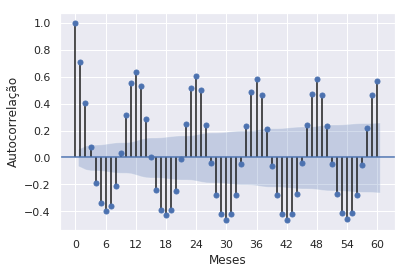

In [7]:
plot_acf(furnas, lags=60)
plt.xticks(np.arange(0, 61, step=6))
plt.title('')
plt.ylabel('Autocorrelação')
plt.xlabel('Meses')
plt.show()
plt.rcParams["figure.figsize"] = (14, 8)

# Um único neurônio (regressão linear)

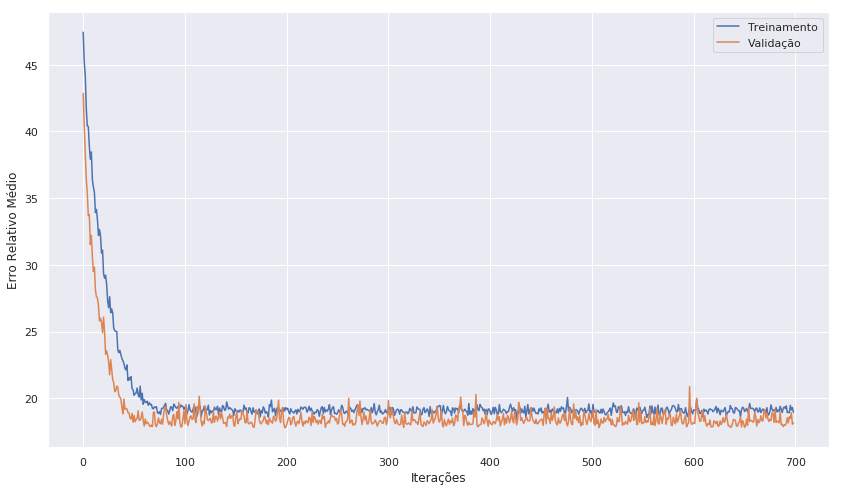

Furnas


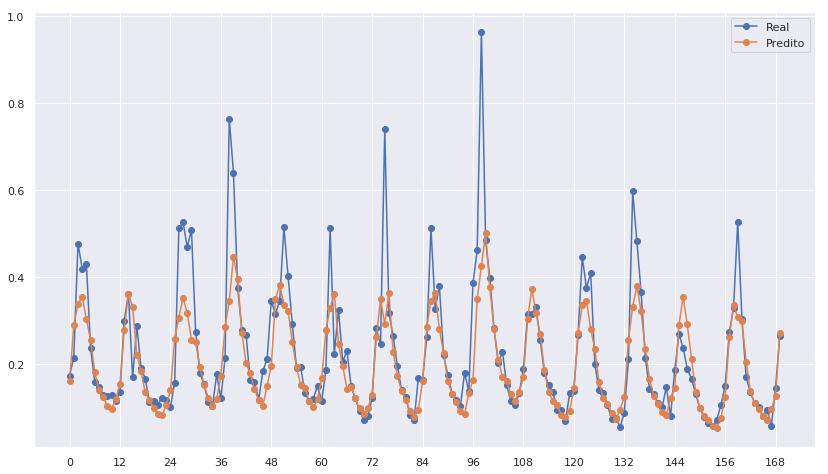

RMSE =  350.9985869054797, MSE =  123200.00800964363, MAPE =  18.719898072131976 %, MAE =  190.19612213800497, R =  0.6189285758078034
Camargos


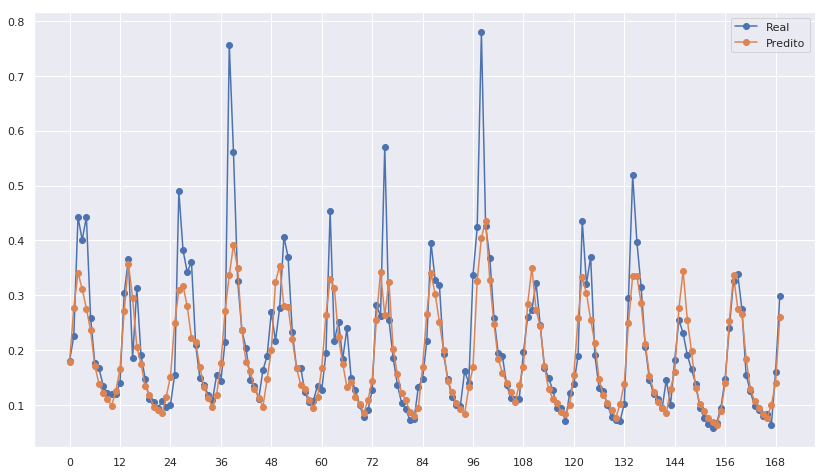

RMSE =  41.56820239580163, MSE =  1727.9154504183277, MAPE =  16.895533869925167 %, MAE =  23.611001157760622, R =  0.6765338486912857


In [8]:
def modelo_uno(janela, quant_rios, ruido=0.05):
    entrada = Input(shape=(janela * quant_rios,))
    mes = Input(shape=(12,), name='mes')
    
    entrada_ruidosa = GaussianDropout(ruido)(entrada)
    entrada_aumentada = Concatenate(axis=-1)([entrada_ruidosa, mes])
    estimativa = Dense(quant_rios, activation='tanh')(entrada_aumentada)
    
    modelo = Model(inputs=[entrada, mes], outputs=estimativa)
    return modelo

if not os.path.isfile('modelos/melhor_uno.h5'):
    uno = modelo_uno(janela, 2)
    uno.compile(optimizer='adam', loss='mape')
    parar_uno = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=500, min_delta=0)
    salvar_uno = ModelCheckpoint('modelos/melhor_uno.h5', monitor='val_loss', mode='min', save_best_only=True)
    
    historico_uno = uno.fit([x_treina, m_treina], y_treina, epochs=10000, validation_data=([x_valida, m_valida], y_valida), verbose=0, callbacks=[parar_uno, salvar_uno])
    salva_historico(historico_uno.history, 'historicos/uno')
    
mostra_treinamento(carrega_historico('historicos/uno'))
uno = load_model('modelos/melhor_uno.h5')
mostra_performance(uno, [x_valida, m_valida], y_valida, fatores_normalizacao)

# Multilayer perceptron

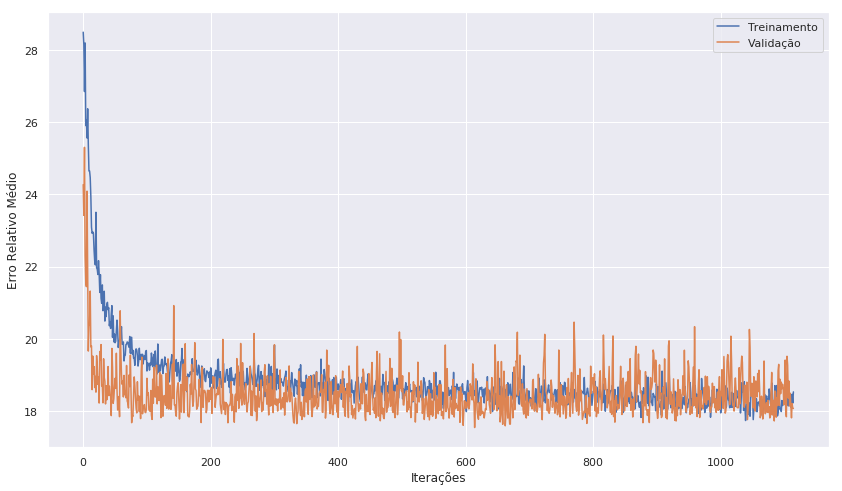

Furnas


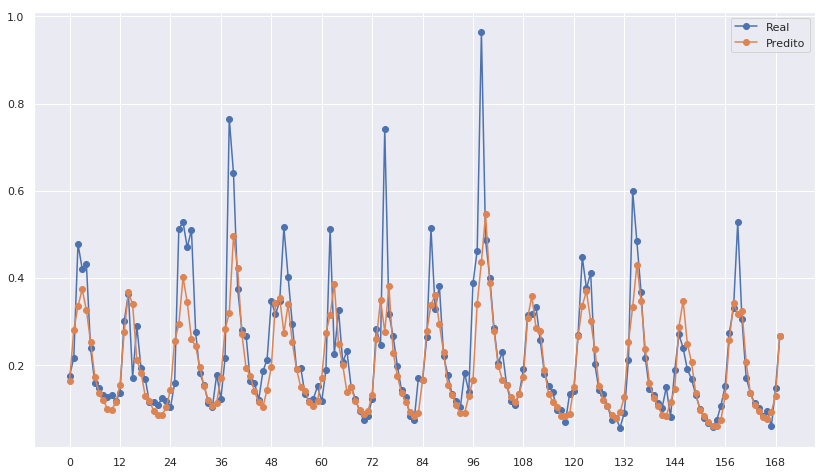

RMSE =  352.7593951022454, MSE =  124439.19083290204, MAPE =  18.563029924045846 %, MAE =  188.90393531361926, R =  0.6150956445367548
Camargos


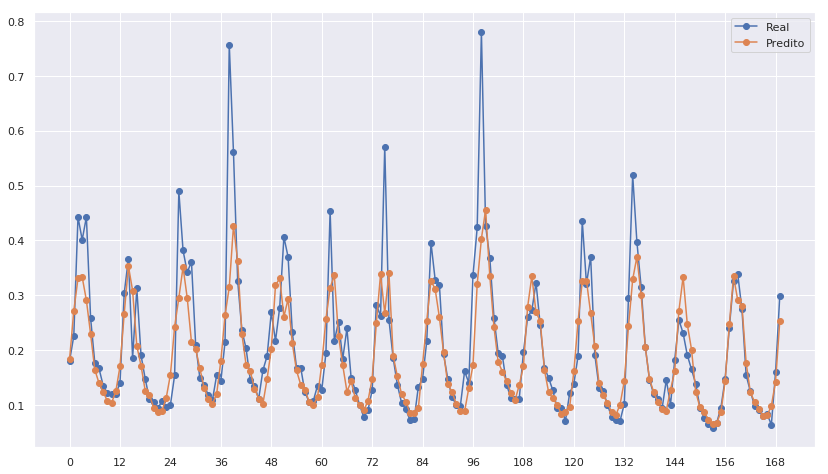

RMSE =  41.689968821576485, MSE =  1738.0535003440195, MAPE =  16.52731359678024 %, MAE =  23.165531046250287, R =  0.6746360035215784


In [9]:
def modelo_mlp(janela, quant_rios, ruido=0.03):
    entrada = Input(shape=(janela*quant_rios,))
    mes = Input(shape=(12,), name='mes')
    
    entrada_ruidosa = GaussianDropout(ruido)(entrada)
    entrada_aumentada = Concatenate(axis=-1)([entrada_ruidosa, mes])
    X = Dense(8, activation='relu', kernel_regularizer=regularizers.l1(0.0001))(entrada_aumentada)
    X = Dense(12, activation='tanh')(entrada_aumentada)
    X = GaussianDropout(0.003)(X)
    X = Dense(6, activation='tanh')(X)
    X = GaussianDropout(0.001)(X)
    estimativa = Dense(quant_rios)(X)
    
    modelo = Model(inputs=[entrada, mes], outputs=estimativa)
    return modelo

if not os.path.isfile('modelos/melhor_mlp.h5'):
    mlp = modelo_mlp(janela, 2)
    mlp.compile(optimizer='adam', loss='mape')
    parar_mlp = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=500, min_delta=0)
    salvar_mlp = ModelCheckpoint('modelos/melhor_mlp.h5', monitor='val_loss', mode='min', save_best_only=True)
    
    historico_mlp = mlp.fit([x_treina, m_treina], y_treina, epochs=10000, validation_data=([x_valida, m_valida], y_valida), verbose=0, callbacks=[parar_mlp, salvar_mlp])
    salva_historico(historico_mlp.history, 'historicos/mlp')

mostra_treinamento(carrega_historico('historicos/mlp'))
mlp = load_model('modelos/melhor_mlp.h5')
mostra_performance(mlp, [x_valida, m_valida], y_valida, fatores_normalizacao)

## Divisão do conjuntos de dados para redes recorrentes

Para o treinamento de redes recorrentes no Keras é necessário escrever um tensor de ordem 3

In [10]:
janela_reco = janela + adicional_reco
valida_reco = int((len(furnas) - teste - janela_reco) * fracao_valida)
treino_reco = len(furnas) - teste - valida_reco - janela_reco

x_treina_reco, y_treina_reco = separa_series_reco(furnas, camargos, janela_reco, janela_reco, treino_reco)
m_treina_reco = gera_meses_reco(janela_reco, janela_reco, treino_reco)
x_valida_reco, y_valida_reco = separa_series_reco(furnas, camargos, janela_reco, janela_reco+treino_reco, valida_reco)
m_valida_reco = gera_meses_reco(janela_reco, janela_reco+treino_reco, valida_reco)
x_teste_reco, y_teste_reco = separa_series_reco(furnas, camargos, janela_reco, janela_reco+treino_reco+valida_reco, teste)
m_teste_reco = gera_meses_reco(janela_reco, janela_reco+treino_reco+valida_reco, teste)

assert(x_treina_reco[31, -1, -1] == y_treina_reco[30, -1])
print('Treino, ', treino_reco)
print('Validação, ', valida_reco)
print('Teste, ', teste)
print('Total, ', len(furnas) - janela_reco)

Treino,  634
Validação,  158
Teste,  120
Total,  912


## Rede Recorrente Simples

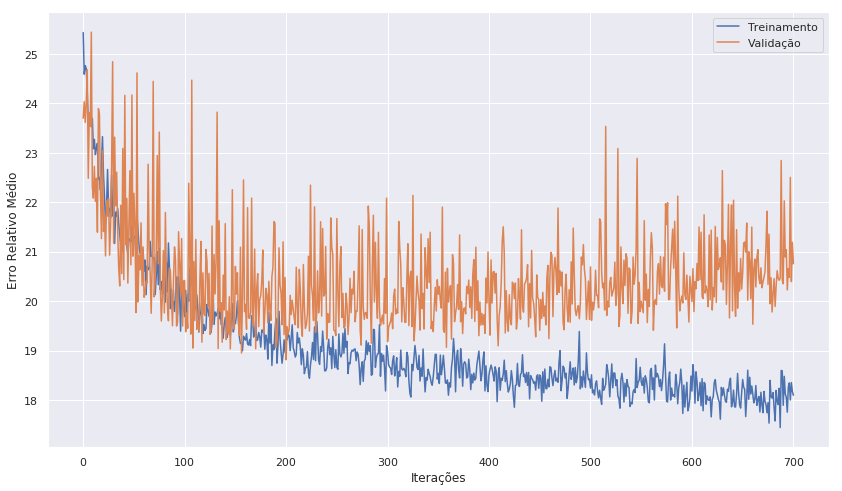

/usr/lib64/python3.6/site-packages/theano/gpuarray/dnn.py:184: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to a version >= v5 and <= v7.
  warnings.warn("Your cuDNN version is more recent than "


Furnas


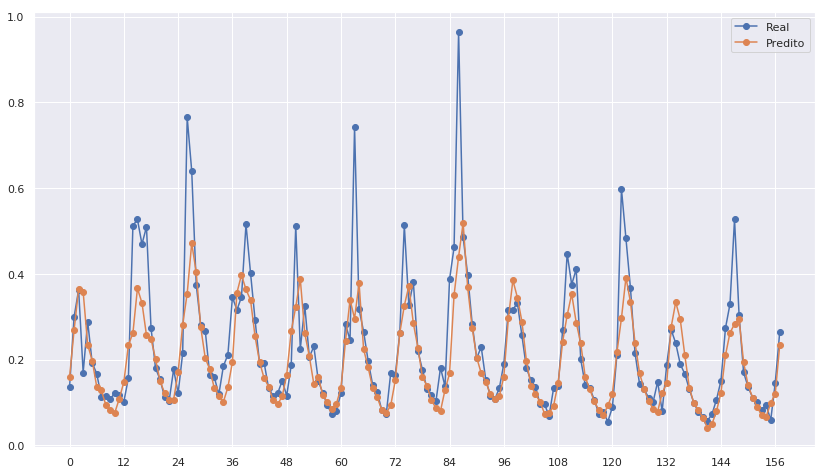

RMSE =  362.89306849800215, MSE =  131691.3791638957, MAPE =  20.13216588191999 %, MAE =  201.04521786487555, R =  0.6012007151146674
Camargos


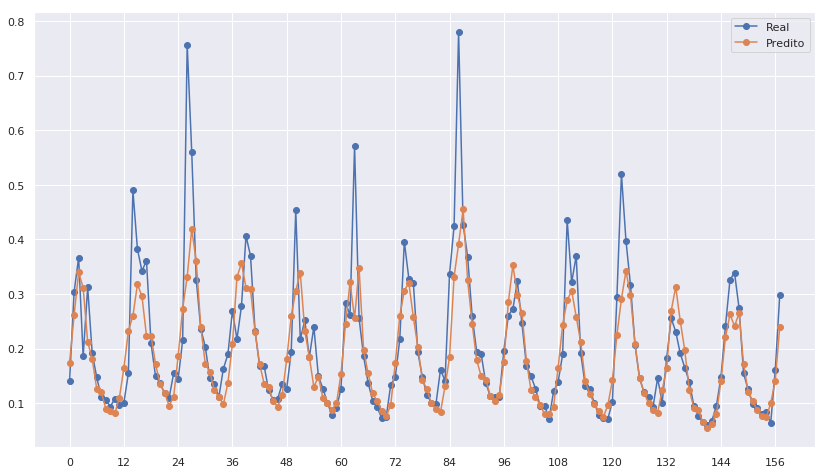

RMSE =  43.587234044768024, MSE =  1899.8469716733848, MAPE =  17.277023230960367 %, MAE =  24.370532298389872, R =  0.6454967666240341


<IPython.core.display.Javascript object>

In [11]:
def modelo_reco(janela, quant_rios, ruido=0.03):
    entrada = Input(shape=(janela, quant_rios))
    mes = Input(shape=(janela, 12), name='mes')
    
    entrada_ruidosa = GaussianDropout(ruido)(entrada)
    entrada_aumentada = Concatenate(axis=-1)([entrada_ruidosa, mes])
    X = Dense(12, activation='tanh', kernel_regularizer=regularizers.l2(0.01))(entrada_aumentada)
    X = GaussianDropout(0.004)(X)
    X = SimpleRNN(12)(X)
    X = GaussianDropout(0.002)(X)
    X = Dense(6, activation='tanh')(X)
    estimativa = Dense(quant_rios)(X)
    
    modelo = Model(inputs=[entrada, mes], outputs=estimativa)
    return modelo

if not os.path.isfile('modelos/melhor_reco.h5'):
    reco = modelo_reco(janela_reco, 2)
    reco.compile(optimizer='adam', loss='mape')
    parar_reco = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=500, min_delta=0)
    salvar_reco = ModelCheckpoint('modelos/melhor_reco.h5', monitor='val_loss', mode='min', save_best_only=True)
    
    historico_reco = reco.fit([x_treina_reco, m_treina_reco], y_treina_reco, epochs=10000, validation_data=([x_valida_reco, m_valida_reco], y_valida_reco), verbose=0, callbacks=[parar_reco, salvar_reco])
    salva_historico(historico_reco.history, 'historicos/reco')

mostra_treinamento(carrega_historico('historicos/reco'))
reco = load_model('modelos/melhor_reco.h5')
mostra_performance(reco, [x_valida_reco, m_valida_reco], y_valida_reco, fatores_normalizacao)

# LSTM

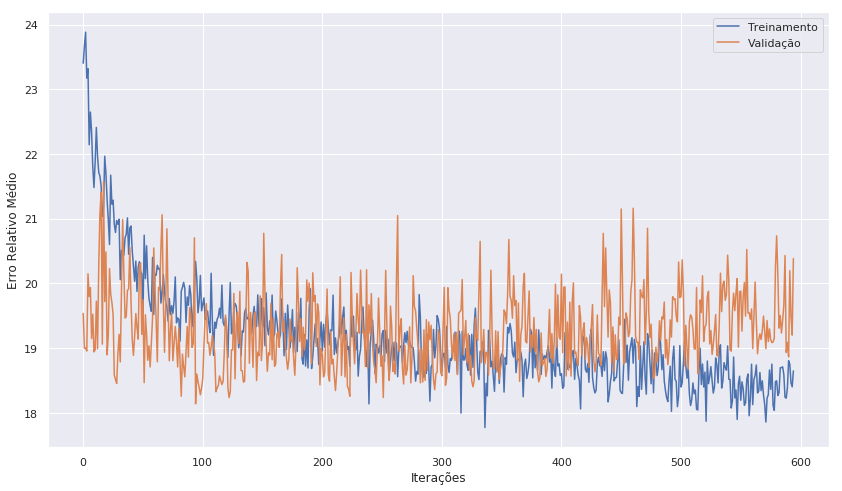

Furnas


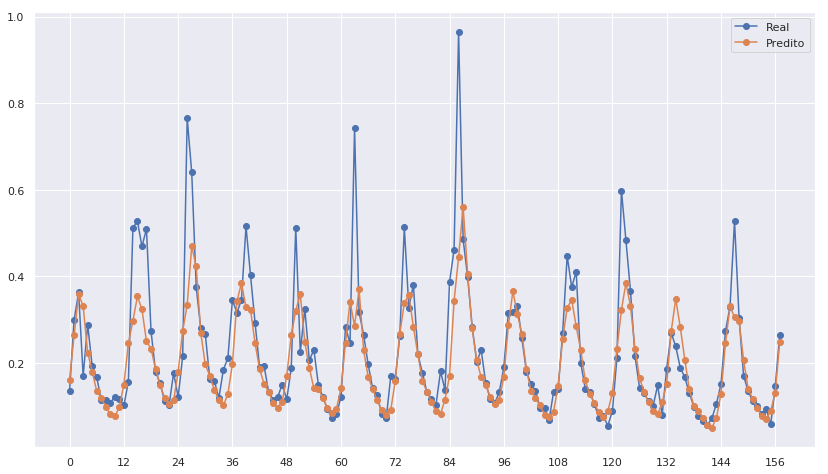

RMSE =  359.55202963105455, MSE =  129277.66201181075, MAPE =  19.37738987158245 %, MAE =  196.53370698692302, R =  0.6085101432661408
Camargos


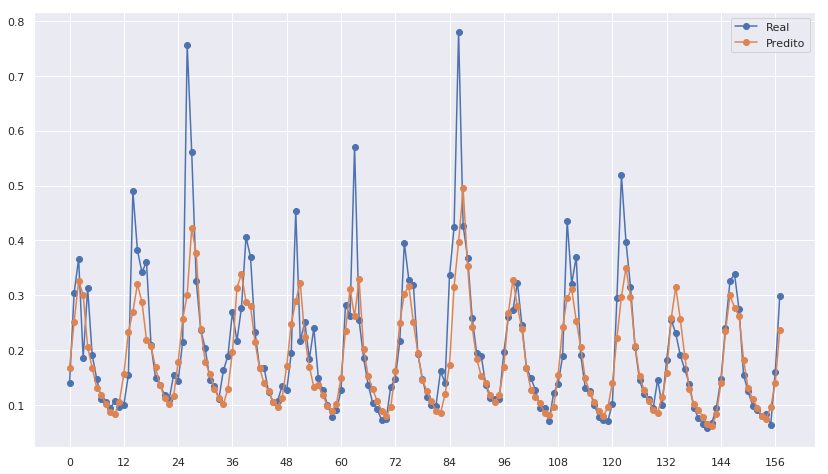

RMSE =  43.69572573678186, MSE =  1909.3164476640604, MAPE =  16.89868566846006 %, MAE =  24.009285356425032, R =  0.6437298033332413


<IPython.core.display.Javascript object>

In [12]:
def modelo_lstm(janela, quant_rios, ruido=0.03):
    entrada = Input(shape=(janela, quant_rios))
    mes = Input(shape=(janela, 12), name='mes')
    
    entrada_ruidosa = GaussianDropout(ruido)(entrada)
    entrada_aumentada = Concatenate(axis=-1)([entrada_ruidosa, mes])
    X = Dense(24, activation='tanh')(entrada_aumentada)
    X = Dropout(rate=0.1)(X)
    X = LSTM(24)(entrada_aumentada)
    X = Dropout(rate=0.2)(X)
    X = Dense(6, activation='tanh')(X)
    X = Dropout(rate=0.1)(X)
    estimativa = Dense(quant_rios)(X)
    
    modelo = Model(inputs=[entrada, mes], outputs=estimativa)
    return modelo

if not os.path.isfile('modelos/melhor_lstm.h5'):
    lstm = modelo_lstm(janela_reco, 2)
    lstm.compile(optimizer='adam', loss='mape')
    parar_lstm = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=500, min_delta=0, restore_best_weights=True)
    salvar_lstm = ModelCheckpoint('modelos/melhor_lstm.h5', monitor='val_loss', mode='min', save_best_only=True)
    historico_lstm = lstm.fit([x_treina_reco, m_treina_reco], y_treina_reco, epochs=7500, validation_data=([x_valida_reco, m_valida_reco], y_valida_reco), verbose=0, callbacks=[parar_lstm, salvar_lstm])

    salva_historico(historico_lstm.history, 'historicos/lstm')

mostra_treinamento(carrega_historico('historicos/lstm'))
lstm = load_model('modelos/melhor_lstm.h5')
mostra_performance(lstm, [x_valida_reco, m_valida_reco], y_valida_reco, fatores_normalizacao)

## GRU

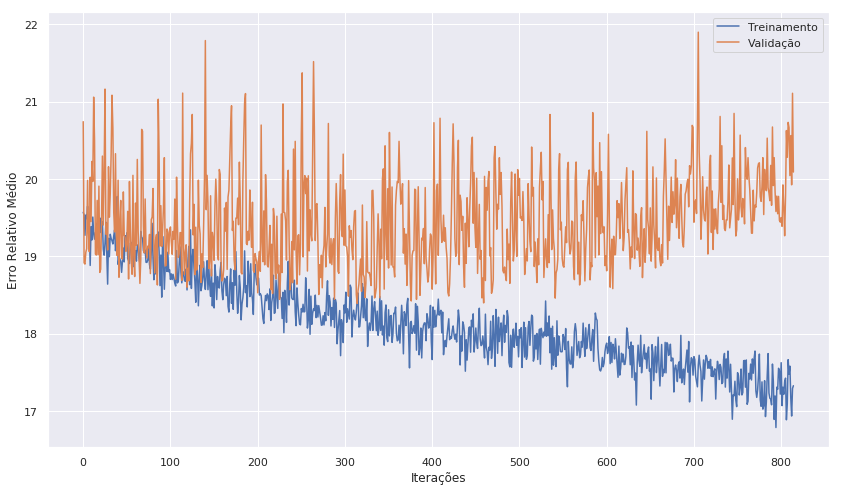

Furnas


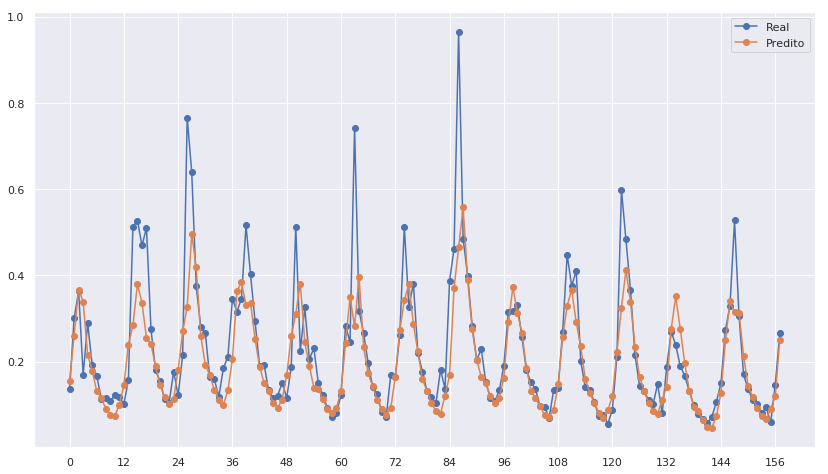

RMSE =  356.0486276023878, MSE =  126770.62521754384, MAPE =  19.556007354559153 %, MAE =  195.9271993682119, R =  0.616102170072167
Camargos


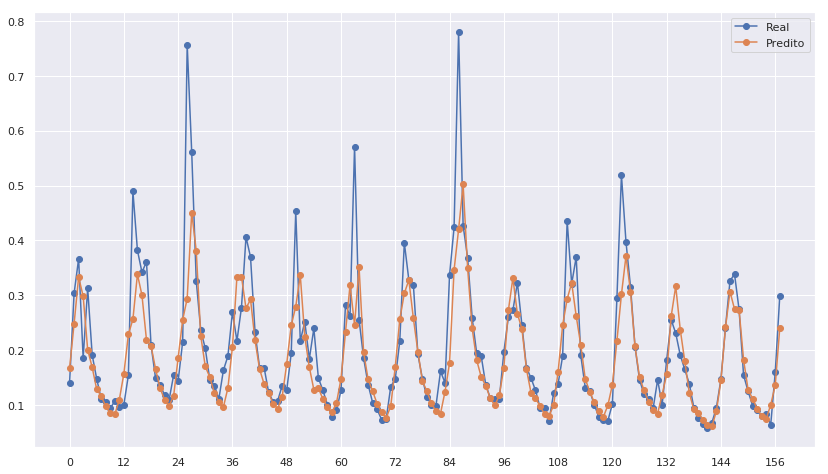

RMSE =  43.769326292523814, MSE =  1915.7539241014167, MAPE =  16.898852432228765 %, MAE =  23.886370556263984, R =  0.642528598054158


<IPython.core.display.Javascript object>

In [13]:
def modelo_gru(janela, quant_rios, ruido=0.03):
    entrada = Input(shape=(janela, quant_rios))
    mes = Input(shape=(janela, 12), name='mes')
    
    entrada_ruidosa = GaussianDropout(ruido)(entrada)
    entrada_aumentada = Concatenate(axis=-1)([entrada_ruidosa, mes])
    X = Dense(12, activation='tanh', kernel_regularizer=regularizers.l2(0.02))(entrada_aumentada)
    X = GaussianDropout(0.004)(X)
    X = GRU(9)(X)
    X = GaussianDropout(0.002)(X)
    X = Dense(6, activation='tanh')(X)
    estimativa = Dense(quant_rios)(X)
    
    modelo = Model(inputs=[entrada, mes], outputs=estimativa)
    return modelo

if not os.path.isfile('modelos/melhor_gru.h5'):
    gru = modelo_gru(janela_reco, 2)
    gru.compile(optimizer='adam', loss='mape')
    parar_gru = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=500, min_delta=0)
    salvar_gru = ModelCheckpoint('modelos/melhor_gru.h5', monitor='val_loss', mode='min', save_best_only=True)
    
    historico_gru = gru.fit([x_treina_reco, m_treina_reco], y_treina_reco, epochs=2000, validation_data=([x_valida_reco, m_valida_reco], y_valida_reco), verbose=0, callbacks=[parar_gru, salvar_gru])
    salva_historico(historico_gru.history, 'historicos/gru')

mostra_treinamento(carrega_historico('historicos/gru'))
gru = load_model('modelos/melhor_gru.h5')
mostra_performance(gru, [x_valida_reco, m_valida_reco], y_valida_reco, fatores_normalizacao)

## Teste dos modelos

Essas avaliações devem ser executados somente após a escolha definitiva dos modelos, para que os hiperparâmetros não se tornem enviesados ao conjunto de teste.

Único Neurônio
Furnas


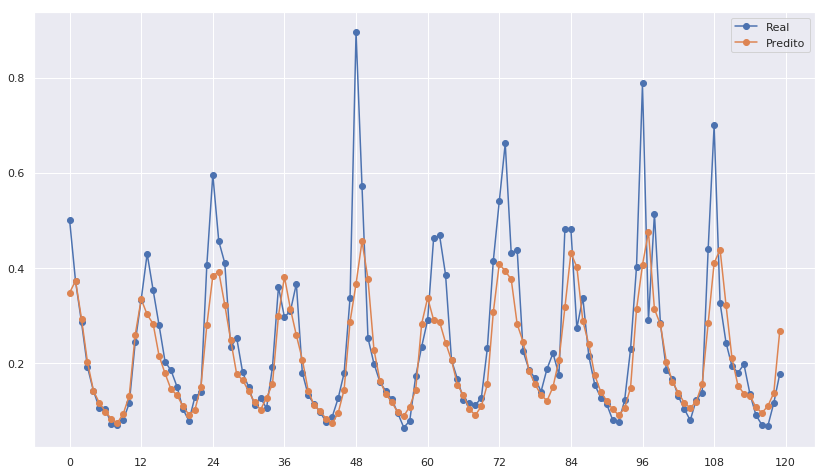

RMSE =  366.34366297517255, MSE =  134207.67940206683, MAPE =  19.280047854521897 %, MAE =  214.16388938159994, R =  0.6413976613455543
Camargos


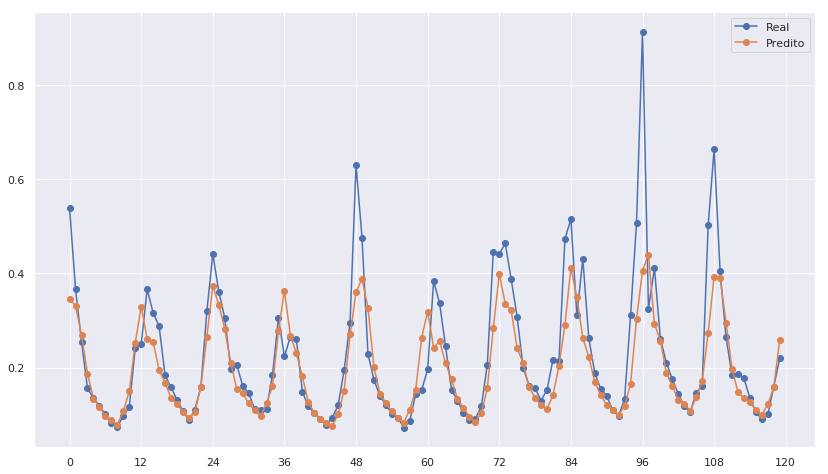

RMSE =  49.24665243558293, MSE =  2425.2327761111064, MAPE =  16.033334854485233 %, MAE =  27.28311056296031, R =  0.6488003769502624



MLP
Furnas


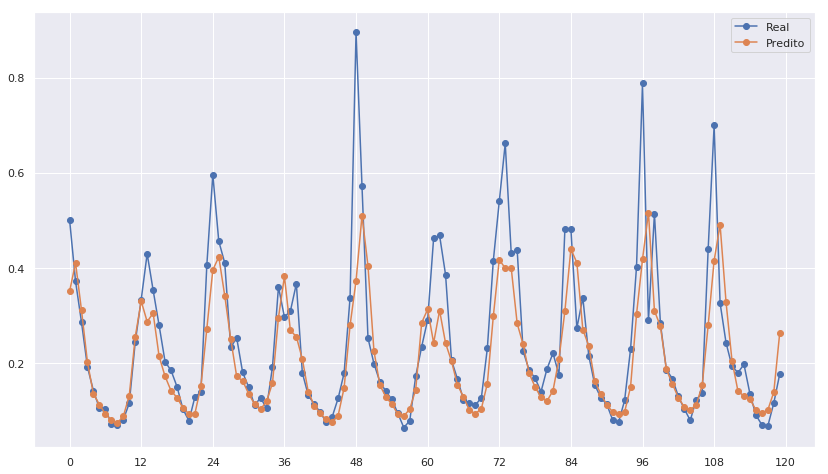

RMSE =  370.40059810446206, MSE =  137196.60307614322, MAPE =  19.476105980012758 %, MAE =  217.50759729718172, R =  0.6334112702213001
Camargos


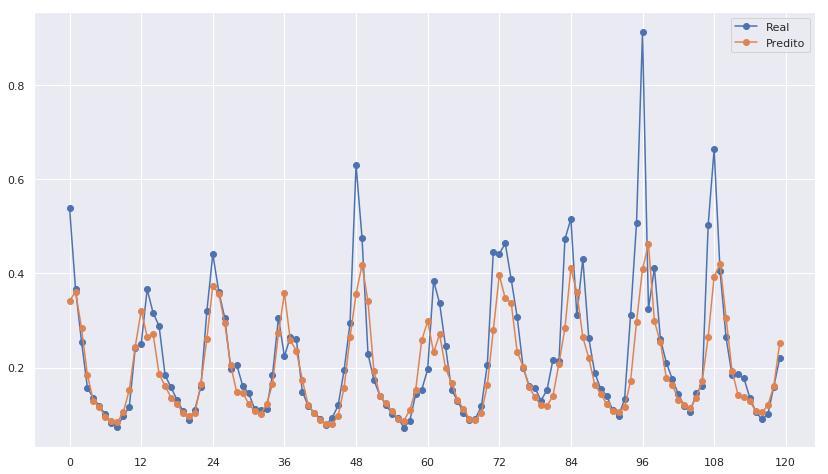

RMSE =  49.24176256898545, MSE =  2424.751180900337, MAPE =  15.783415530906234 %, MAE =  26.861617235342663, R =  0.6488701170833131



Recorrente Simples
Furnas


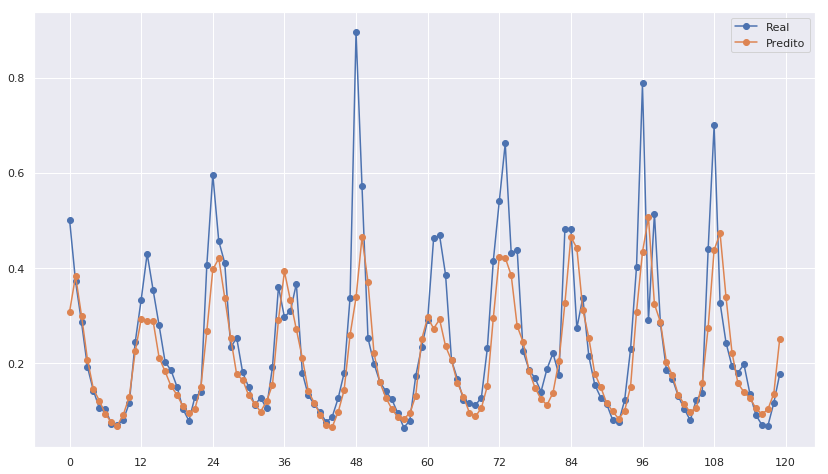

RMSE =  370.8100161275724, MSE =  137500.06806053047, MAPE =  19.591070841033815 %, MAE =  217.87921263482423, R =  0.6326004130960905
Camargos


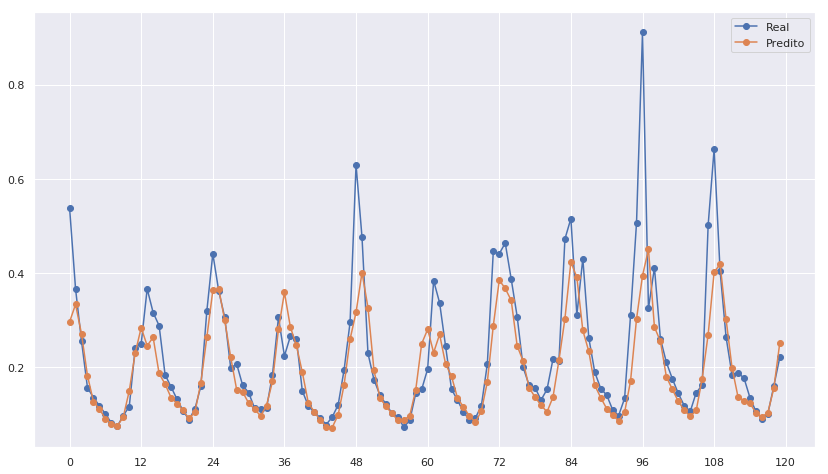

RMSE =  50.20022758177574, MSE =  2520.062849262078, MAPE =  16.354343729544134 %, MAE =  27.627713227272032, R =  0.6350679689635108



LSTM
Furnas


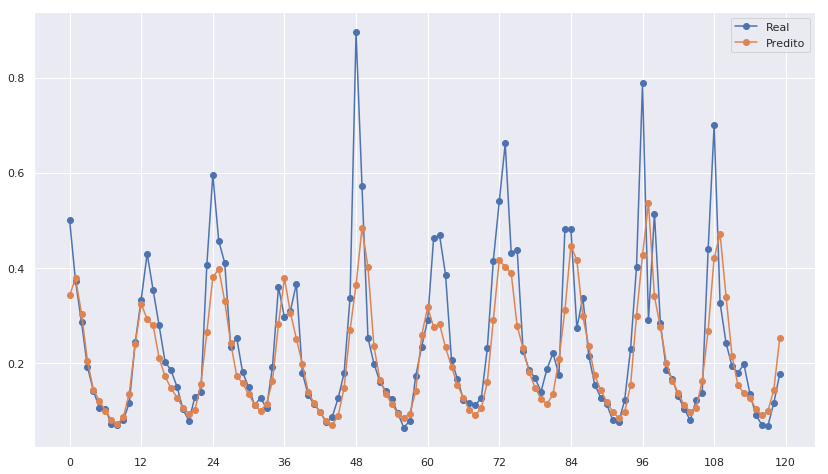

RMSE =  372.7919188387782, MSE =  138973.8147514982, MAPE =  19.28025097527896 %, MAE =  218.27654841126255, R =  0.6286625683146305
Camargos


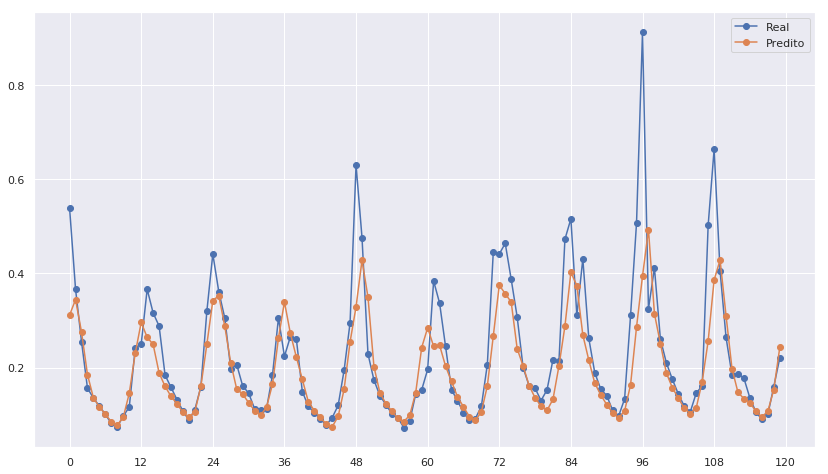

RMSE =  51.14362208880527, MSE =  2615.670080362531, MAPE =  15.996143977998473 %, MAE =  27.962410485744474, R =  0.6212230202006337



GRU
Furnas


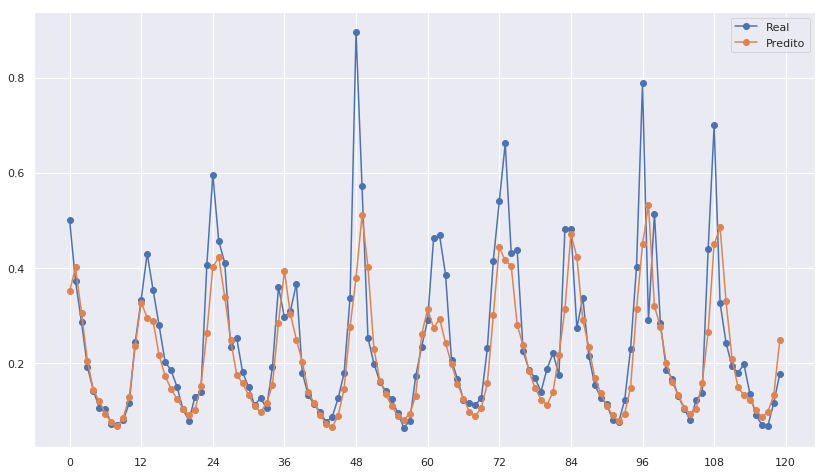

RMSE =  359.60721027409187, MSE =  129317.34568111492, MAPE =  18.667941317849166 %, MAE =  210.62563918145997, R =  0.6544646118877827
Camargos


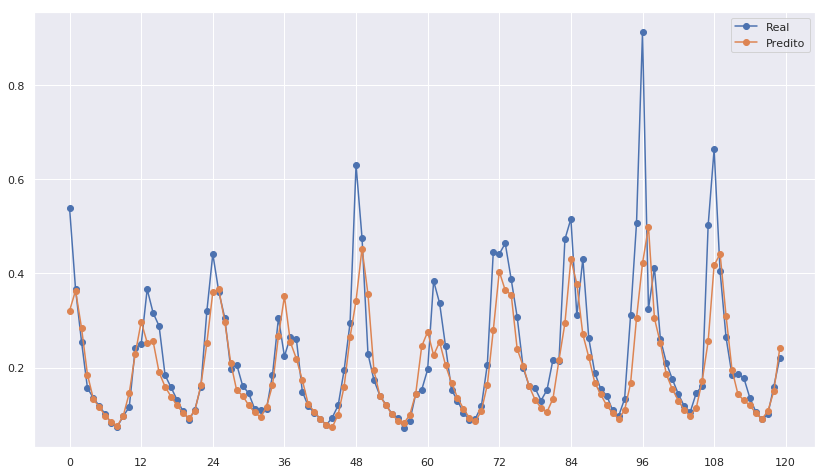

RMSE =  49.10672284516112, MSE =  2411.4702285914686, MAPE =  15.683865585873397 %, MAE =  26.940378415584565, R =  0.6507933409035418


In [14]:
executar_testes = True

if executar_testes:
    print('Único Neurônio')
    mostra_performance(uno, [x_teste, m_teste], y_teste, fatores_normalizacao, True)
    print('\n\n\nMLP')
    mostra_performance(mlp, [x_teste, m_teste], y_teste, fatores_normalizacao, True)
    print('\n\n\nRecorrente Simples')
    mostra_performance(reco, [x_teste_reco, m_teste_reco], y_teste_reco, fatores_normalizacao, True)
    print('\n\n\nLSTM')
    mostra_performance(lstm, [x_teste_reco, m_teste_reco], y_teste_reco, fatores_normalizacao, True)
    print('\n\n\nGRU')
    mostra_performance(gru , [x_teste_reco, m_teste_reco], y_teste_reco, fatores_normalizacao, True)